In [2]:
# read data from dataset table
import pandas as pd
import numpy as np
import re

# NLTK for text preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# split datas as train-test
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
# convert data from text to numbers
from sklearn.feature_extraction.text import TfidfVectorizer

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation metrics (accuracy, confusion matrix, reports, ROC curve)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
# Pipeline for chaining vectorizer + model
from sklearn.pipeline import Pipeline
# Combine sparse text features with numeric features
from scipy.sparse import hstack

# showing it graphically and in diagrams
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources (only needed once)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to C:\Users\Monster Huma H5
[nltk_data]     v4.1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Monster Huma H5
[nltk_data]     v4.1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\Monster Huma H5
[nltk_data]     v4.1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Monster Huma H5
[nltk_data]     v4.1\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv("balanced_imdb_comments.csv")
df.head()

,review_text,label,rating,movie_id
0,"Truth be told, The Matrix is a film I've watch...",negative,2,tt0133093
1,Based on the long-running hype surrounding thi...,negative,4,tt0120737
2,"With Edward Norton and Brad Pitt leading, grea...",positive,10,tt0137523
3,Not sure what to make of it. I had really high...,neutral,5,tt0372784
4,"Well here it is, one of the most anticipated m...",positive,10,tt0468569


In [4]:
# Function to create extra numeric features from the text
def extra_custom_features(df):
    # Count total characters
    df['char_count'] = df['review_text'].apply(len)
    # Count how many "!" characters appear
    df['exclamation_count'] = df['review_text'].apply(lambda x: str(x).count('!'))
    # Count how many "?" characters appear
    df['question_count'] = df['review_text'].apply(lambda x: str(x).count('?'))

    return df

df = extra_custom_features(df)
df

,review_text,label,rating,movie_id,char_count,exclamation_count,question_count
0,"Truth be told, The Matrix is a film I've watch...",negative,2,tt0133093,4576,0,1
1,Based on the long-running hype surrounding thi...,negative,4,tt0120737,3765,0,2
2,"With Edward Norton and Brad Pitt leading, grea...",positive,10,tt0137523,618,0,0
3,Not sure what to make of it. I had really high...,neutral,5,tt0372784,1154,1,1
4,"Well here it is, one of the most anticipated m...",positive,10,tt0468569,2128,1,1
...,...,...,...,...,...,...,...
2095,I agree that the latest movies from the Star W...,negative,1,tt3778644,378,0,0
2096,I hated this movie more than I can begin to ex...,negative,4,tt0167261,928,0,0
2097,"Moving forward from A New Hope, I now arrived ...",negative,2,tt0080684,3402,0,1
2098,"Actually, I have little to add to the majority...",neutral,5,tt0209144,1864,1,1


In [5]:
# if data is already cleaned, this part can be skipped
# Load English stopwords and keep important negation words
stop_words = set(stopwords.words('english'))
stop_words -= {'not','no','nor','neither','never'}# keep negations
lemmatizer = WordNetLemmatizer()

def clean_text_data(text):
    text = text.lower()        # convert to lowercase
    text = re.sub(r"http\S+|www\S+","", text)     #remove links
    text = re.sub(r"[^a-z\s]","", text)       #remove symbols and numbers
    text = re.sub(r"\s+"," ", text).strip()     #remove extra spaces

    tokens = word_tokenize(text)      # tokenize into words
    # remove stopwords and apply lemmatization
    filtered_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(filtered_tokens)

# Create a cleaned text column
df["clean_text"] = df["review_text"].apply(clean_text_data)
df

,review_text,label,rating,movie_id,char_count,exclamation_count,question_count,clean_text
0,"Truth be told, The Matrix is a film I've watch...",negative,2,tt0133093,4576,0,1,truth told matrix film ive watched many time k...
1,Based on the long-running hype surrounding thi...,negative,4,tt0120737,3765,0,2,based longrunning hype surrounding movie not m...
2,"With Edward Norton and Brad Pitt leading, grea...",positive,10,tt0137523,618,0,0,edward norton brad pitt leading greatness inev...
3,Not sure what to make of it. I had really high...,neutral,5,tt0372784,1154,1,1,not sure make really high hope reading positiv...
4,"Well here it is, one of the most anticipated m...",positive,10,tt0468569,2128,1,1,well one anticipated movie year far excellent ...
...,...,...,...,...,...,...,...,...
2095,I agree that the latest movies from the Star W...,negative,1,tt3778644,378,0,0,agree latest movie star war franchise far wors...
2096,I hated this movie more than I can begin to ex...,negative,4,tt0167261,928,0,0,hated movie begin explain hated worse scene wo...
2097,"Moving forward from A New Hope, I now arrived ...",negative,2,tt0080684,3402,0,1,moving forward new hope arrived beloved star w...
2098,"Actually, I have little to add to the majority...",neutral,5,tt0209144,1864,1,1,actually little add majority comment listed si...


In [6]:
# Map text labels to numeric labels
label_map = {
    "negative":0,
    "neutral":1,
    "positive":2
}

# Apply numeric encoding to the label column
df["label_encoded"] = df["label"].map(label_map)
df["label_encoded"].value_counts()

label_encoded
0    700
2    700
1    700
Name: count, dtype: int64

In [7]:
# Select input (text) and target (labels)
x = df["clean_text"]
y = df["label_encoded"]

# Split data into training (80%) and testing (20%)
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # stratify=y keeps class distribution balanced across splits
)

# Shows number of samples in each split
print("train size:", x_train.shape[0])
print("test size:", x_test.shape[0])

train size: 1680
test size: 420


In [8]:
# Convert text into numeric TF-IDF vectors (top 3000 features)
vectorizer = TfidfVectorizer(
    max_features=3000
)

# Fit TF-IDF on training data and transform both train & test sets
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

# Show resulting matrix shapes (rows = samples, columns = features)
print("Train TF-IDF shape:", x_train_tfidf.shape)
print("Test TF-IDF shape:", x_test_tfidf.shape)

Train TF-IDF shape: (1680, 3000)
Test TF-IDF shape: (420, 3000)


In [9]:
# Scale numeric custom features
scaler = StandardScaler()

# Select custom features based on train/test indices
train_custom = df.loc[x_train.index, ["char_count", "exclamation_count", "question_count"]]
test_custom  = df.loc[x_test.index,  ["char_count", "exclamation_count", "question_count"]]

# Fit scaler on train data and apply to both train & test
train_custom_scaled = scaler.fit_transform(train_custom)
test_custom_scaled  = scaler.transform(test_custom)

# Combine TF-IDF features with the scaled custom features
x_train_final = hstack([x_train_tfidf, train_custom_scaled])
x_test_final  = hstack([x_test_tfidf, test_custom_scaled])

Logistic Regression Accuracy: 0.680952380952381
Confusion Matrix:
[[ 82  44  14]
 [ 38  85  17]
 [ 12   9 119]]


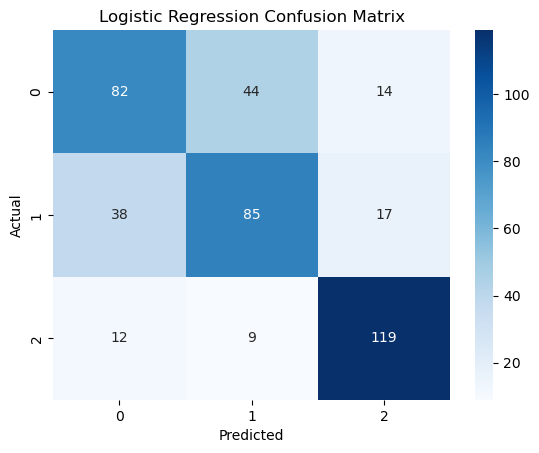

In [11]:
# Train Logistic Regression model
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight = "balanced",
)

# Fit model on training data
lr_model.fit(x_train_final, y_train)

# Predict labels for test data
y_pred_lr = lr_model.predict(x_test_final)

# Calculate accuracy score and confusion matrix
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_cm = confusion_matrix(y_test, y_pred_lr)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Confusion Matrix:")
print(lr_cm)

# Visualize confusion matrix
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [12]:
# Print detailed classification metrics for each class
print("Logistic Regression Classification Report:")
print(classification_report(
    y_test, 
    y_pred_lr, 
    target_names=["negative","neutral","positive"],
    zero_division = 0
))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.59      0.60       140
     neutral       0.62      0.61      0.61       140
    positive       0.79      0.85      0.82       140

    accuracy                           0.68       420
   macro avg       0.68      0.68      0.68       420
weighted avg       0.68      0.68      0.68       420



SVM Accuracy: 0.6761904761904762
Confusion Matrix:
[[ 79  47  14]
 [ 36  89  15]
 [ 12  12 116]]


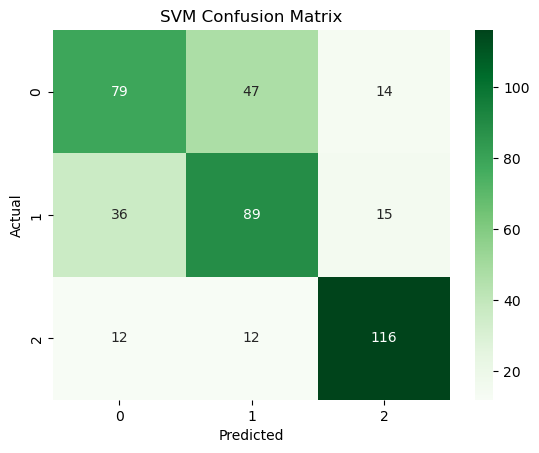

In [13]:
# Train SVM model with a linear kernel
svm_model = SVC(
    kernel = "linear",
    class_weight = "balanced"
)

# Fit model on the training features
svm_model.fit(x_train_final, y_train)

# Predict labels on the test set
y_pred_svm = svm_model.predict(x_test_final)

# Calculate accuracy score and compute confusion matrix
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_cm = confusion_matrix(y_test, y_pred_svm)

print("SVM Accuracy:", svm_accuracy)
print("Confusion Matrix:")
print(svm_cm)

# Visualize confusion matrix
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Greens")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Decision Tree Accuracy: 0.5714285714285714
Confusion Matrix:
[[65 59 16]
 [41 79 20]
 [19 25 96]]


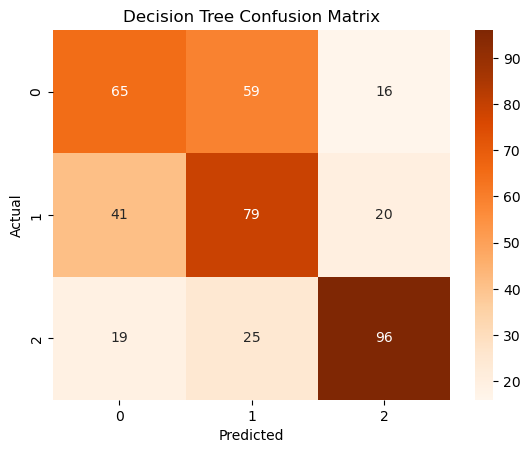

In [18]:
# Train a Decision Tree classifier
dt_model = DecisionTreeClassifier(
    max_depth = 15,
    random_state=42
)

# Fit model on training data
dt_model.fit(x_train_final, y_train)

# Predict labels on test data
y_pred_dt = dt_model.predict(x_test_final)

# Calculate accuracy score and compute confusion matrix
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_cm = confusion_matrix(y_test, y_pred_dt)

print("Decision Tree Accuracy:", dt_accuracy)
print("Confusion Matrix:")
print(dt_cm)

# Visualize confusion matrix
sns.heatmap(dt_cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

MLP Accuracy: 0.6214285714285714
Confusion Matrix:
[[ 68  55  17]
 [ 38  83  19]
 [ 17  13 110]]


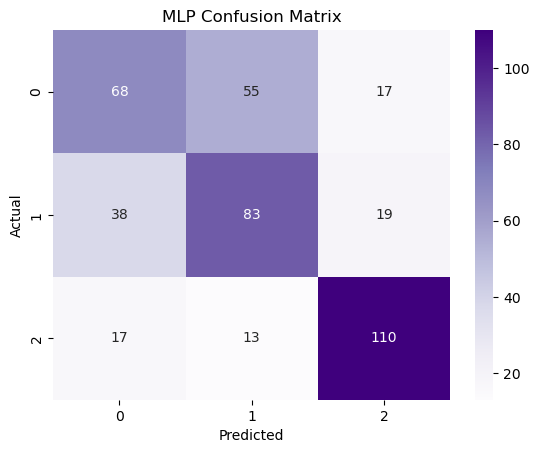

In [19]:
# Train a Neural Network (MLP) classifier
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    max_iter=1000,
    random_state=42
)

# Fit model on training data
mlp_model.fit(x_train_final, y_train)

# Predict labels on test data
y_pred_mlp = mlp_model.predict(x_test_final)

# Calculate accuracy score and compute confusion matrix
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
mlp_cm = confusion_matrix(y_test, y_pred_mlp)

print("MLP Accuracy:", mlp_accuracy)
print("Confusion Matrix:")
print(mlp_cm)

# Visualize confusion matrix
sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Purples")
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
# Create a Pipeline that combines TF-IDF and Logistic Regression
pipeline_lr = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=3000)),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
    ))
])

# Perform 5-fold cross-validation
cv_scores = cross_val_score(
    pipeline_lr,
    df["clean_text"],   # input text data
    df["label_encoded"],   # target labels
    cv=5,       # number of folds
    scoring="accuracy"    # evaluation metric
)

print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
print("Std CV accuracy:", cv_scores.std())

Cross-validation accuracy scores: [0.68571429 0.68333333 0.70238095 0.67142857 0.68809524]
Mean CV accuracy: 0.686190476190476
Std CV accuracy: 0.00992031745523793


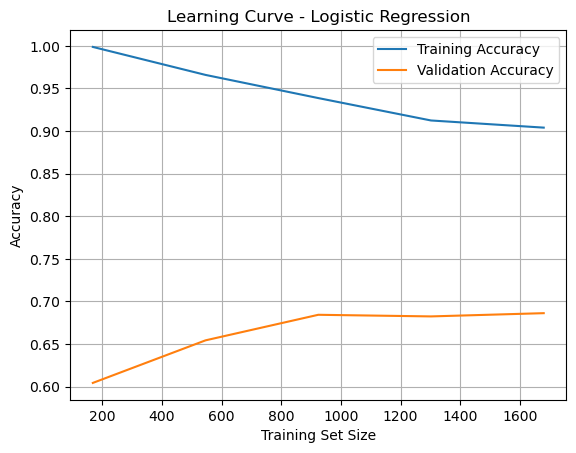

In [17]:
# Compute learning curve for Logistic Regression Pipeline
train_sizes, train_scores, val_scores = learning_curve(
    pipeline_lr,
    df["clean_text"],     # input text data
    df["label_encoded"],   # target labels
    cv=5,     # 5-fold cross validation
    scoring="accuracy",    # metric to evaluate
    train_sizes=np.linspace(0.1, 1.0, 5),  # use 10% to 100% of training data
    n_jobs=-1     # use all CPU cores
)

# Compute mean accuracy for each training size
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

# Plot learning curve
plt.figure()
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Decision Tree", "Neural Network (MLP)"],
    "Accuracy (%)": [lr_accuracy*100, svm_accuracy*100, dt_accuracy*100, mlp_accuracy*100]
})

results

,Model,Accuracy (%)
0,Logistic Regression,68.095238
1,SVM,67.619048
2,Decision Tree,57.142857
3,Neural Network (MLP),62.142857
